In [1]:
# Imports
import time
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.transforms as transforms  # Transformations and augmentations
from torch import optim  # For optimizers
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader #Dataloader module
from torch.utils.data import Dataset # Dataset module
import torchvision.transforms as transforms
from tqdm import tqdm #nice progress bar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm # normal distribution 
import seaborn as sns # nice plots
import math

# Libraries for dataloader
from os import listdir
from os.path import isfile, join


#CUDA configuration
torch.cuda.empty_cache()
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using: {device}')
torch.backends.cudnn.benchmark = True #let cudnn chose the most efficient way of calculating Convolutions
if device == 'cuda':
        #Checking whether GPU RAM is empty
        print('allocated CUDA memory: ',torch.cuda.memory_allocated())
        print('cached CUDA memory: ',torch.cuda.memory_cached())

using: cpu


In [2]:
# load data

df_train = pd.read_csv('train.csv')
df_xtest = pd.read_csv('test.csv')
df_ytest = pd.read_csv('sample_submission.csv')
df_train[0:5]


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


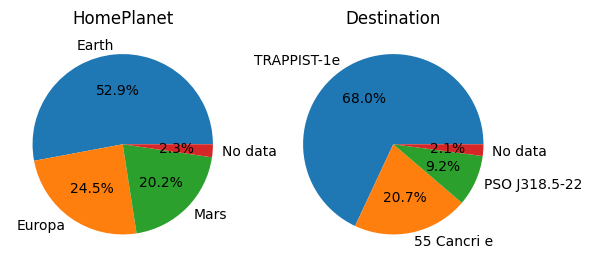

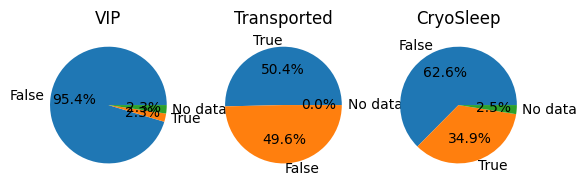

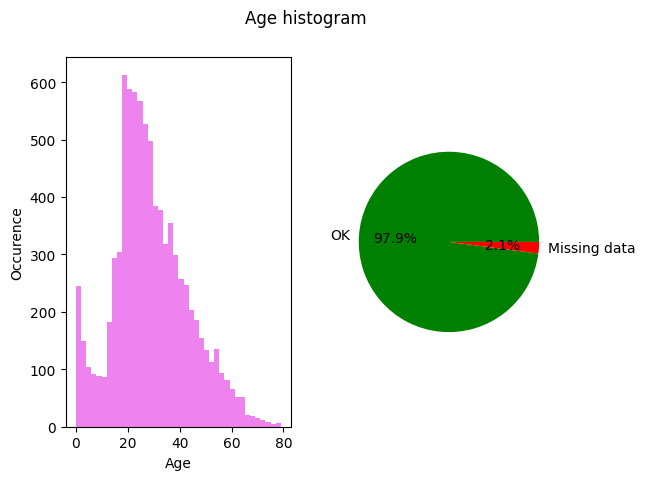

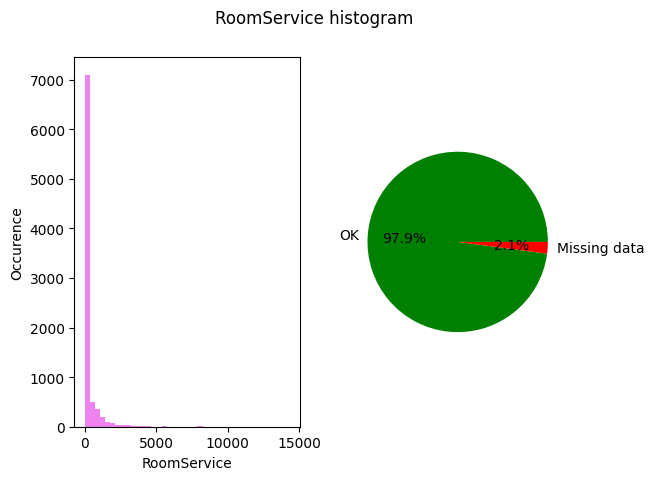

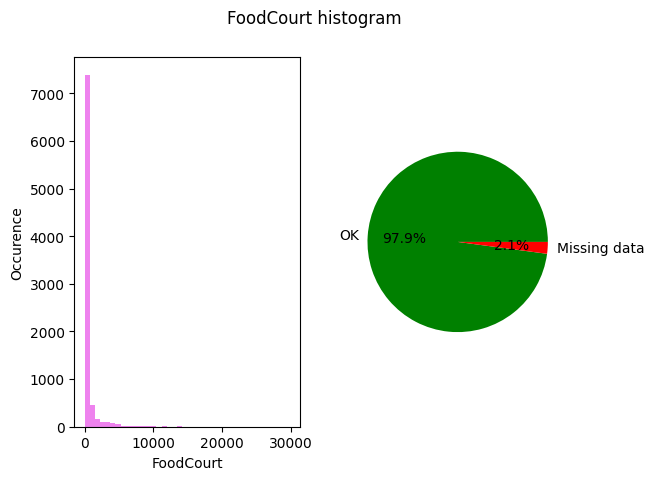

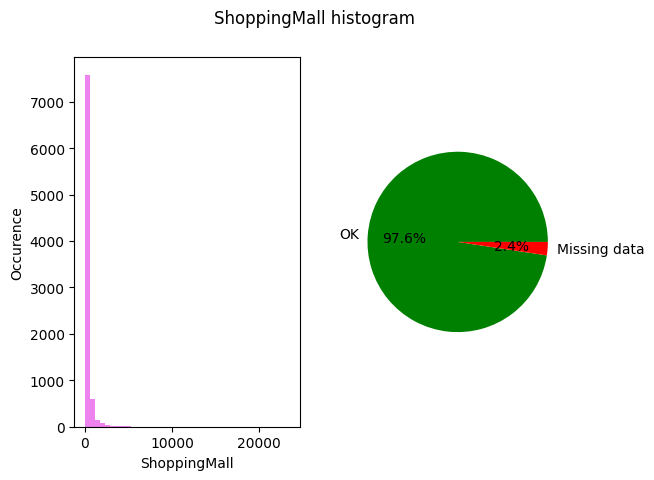

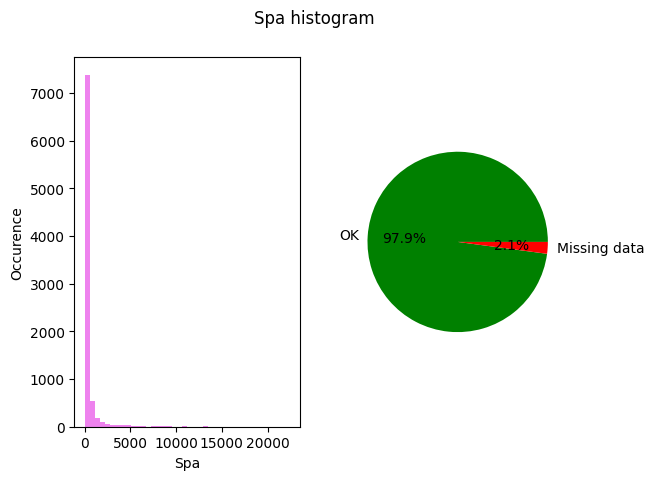

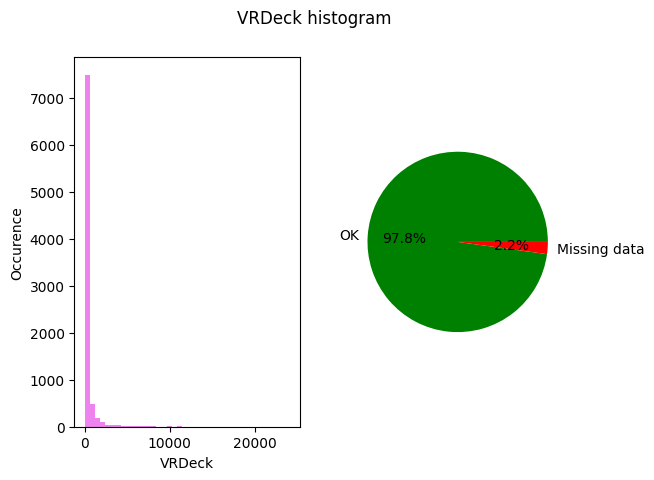

MISSING VALUES
6606 people have 0 missing values.
1867 people have 1 missing values.
203 people have 2 missing values.
17 people have 3 missing values.


In [3]:
# initial data analysis

# pie plots for categorical variables

fig, axis = plt.subplots(1, 2)

for num, name in enumerate(["HomePlanet", "Destination"]):
    num_of_occ = list(df_train[name].value_counts().values)
    lab = list(df_train[name].value_counts().index)
    num_of_occ.append(df_train[name].isna().sum())
    lab.append("No data")

    axis[num].pie(x = num_of_occ, labels = lab, autopct='%1.1f%%')
    axis[num].set_title(name)

plt.show()

# pie plots for boolean variables

fig, axis = plt.subplots(1, 3)

for num, name in enumerate(["VIP", "Transported", "CryoSleep"]):
    num_of_occ = list(df_train[name].value_counts().values)
    lab = list(df_train[name].value_counts().index)
    num_of_occ.append(df_train[name].isna().sum())
    lab.append("No data")

    axis[num].pie(x = num_of_occ, labels = lab, autopct='%1.1f%%')
    axis[num].set_title(name)

plt.show()

# histograms for numerical variables

for name in "Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck":

    fig, axis = plt.subplots(1, 2)
    plt.suptitle(name + " histogram")
    axis[0].hist(df_train[name].values, color ="violet", bins = 40)
    axis[0].set_xlabel(name)
    axis[0].set_ylabel("Occurence")
    data_not_ok = df_train[name].isna().sum()
    data_ok = len(df_train[name].values) - data_not_ok
    axis[1].pie([data_ok, data_not_ok], labels = ["OK", "Missing data"], autopct='%1.1f%%', colors = ["green", "red"] )

    plt.show()

# now a quick check, if NaN values are distributed randomly or if about some people we have completely no data.

nan_list = []
num_people = df_train.shape[0]
nan_people = []

for i in range(num_people):
    nan_list.append(df_train.iloc[i].isna().sum())

nan_list = np.array(nan_list)
unique, counts = np.unique(nan_list, return_counts=True)

print("MISSING VALUES")
for i in range(len(unique)):
    print(str(counts[i]) + " people have " + str(unique[i]) + " missing values.")

In [4]:
# cabin id is sequence of two letters and a number. Maybe those are random values, but maybe they are related to some "sectors" or something
# like that. I'd give a shot to this idea. If chance of being transported has NO relation to those letters than probability of transportation
# has for each letter binomial distribution with p = 0.504. Let's test it.

# at first we divide "cabin" variable into three separate variables
if_transported = []
first_letter = []
for i in range(num_people):
    try: # for case of NaN
        first_letter.append(df_train["Cabin"].values[i][0])
        if_transported.append(df_train["Transported"].values[i])
    except: continue

last_letter = []
for i in range(num_people):
    try:
        last_letter.append(df_train["Cabin"].values[i][-1])
    except: continue

middle_number = []
for i in range(num_people):
    try:
        middle_number.append(df_train["Cabin"].values[i][2:-2])
    except: continue

F_letters, F_occurence = np.unique(np.array(first_letter), return_counts = True)
M_numbers, M_occurence = np.unique(np.array(middle_number), return_counts = True)
L_letters, L_occurence = np.unique(np.array(last_letter), return_counts = True)

# now we calculate percentage of transported people for each letter/number

f_true = []
for f in F_letters:
    x = [if_transported[i] for i in range(len(first_letter)) if first_letter[i] == f]
    f_true.append(x.count(True) / first_letter.count(f))

l_true = []
for l in L_letters:
    x = [if_transported[i] for i in range(len(last_letter)) if last_letter[i] == l]
    l_true.append(x.count(True) / last_letter.count(l))

m_true = []
for m in M_numbers:
    x = [if_transported[i] for i in range(len(middle_number)) if middle_number[i] == m]
    m_true.append(x.count(True) / middle_number.count(m))

# I'll omit "number" variable and focus only on letters

# according to de Laplace-Moivre theorem we can approximate Bernoulli distribution with probability p and n samples with normal distribution with
# mean = pn and variance = np(1-p)

print("P-value for hipothesis that chance of being transported is not correlated to first letter of \'Cabin\'.")

for i in range(len(f_true)):
    sd = np.sqrt(0.504 * 0.496 / F_occurence[i])
    p = 2 * min(norm.cdf(f_true[i], loc = 0.504, scale = sd), norm.cdf(-f_true[i] + 2 * 0.504, loc = 0.504, scale = sd))
    print("For letter \'" + F_letters[i] + "\' p-value is equal to " + str(p))

print("\nP-value for hipothesis that chance of being transported is not correlated to first letter of \'Cabin\'.")
for i in range(len(l_true)):
    sd = np.sqrt(0.504 * 0.496 / L_occurence[i])
    p = 2 * min(norm.cdf(l_true[i], loc = 0.504, scale = sd), norm.cdf(-l_true[i] + 2 * 0.504, loc = 0.504, scale = sd))
    print("For letter \'" + L_letters[i] + "\' p-value is equal to " + str(p))

print("\nConclusion: the probability of transportation depended zajebiście from the Cabin ID.")
print("It might have also depended from numerical part of ID, but I have no idea how to deal with it.")

P-value for hipothesis that chance of being transported is not correlated to first letter of 'Cabin'.
For letter 'A' p-value is equal to 0.8002619566952265
For letter 'B' p-value is equal to 8.103464173798825e-38
For letter 'C' p-value is equal to 6.341047378449715e-22
For letter 'D' p-value is equal to 0.0019202530953443954
For letter 'E' p-value is equal to 3.8285082443534996e-18
For letter 'F' p-value is equal to 1.2042499579512933e-11
For letter 'G' p-value is equal to 0.21642172684013716
For letter 'T' p-value is equal to 0.17396513860467067

P-value for hipothesis that chance of being transported is not correlated to first letter of 'Cabin'.
For letter 'P' p-value is equal to 7.865781421038533e-12
For letter 'S' p-value is equal to 2.319541537475741e-11

Conclusion: the probability of transportation depended zajebiście from the Cabin ID.
It might have also depended from numerical part of ID, but I have no idea how to deal with it.


In [5]:
# cabin id is sequence of two letters and a number. Maybe those are random values, but maybe they are related to some "sectors" or something
# like that. I'd give a shot to this idea. If chance of being transported has NO relation to those letters than probability of transportation
# has for each letter binomial distribution with p = 0.504. Let's test it.

# at first we divide "cabin" variable into three separate variables
if_transported = []
first_letter = []
for i in range(num_people):
    try: # for case of NaN
        first_letter.append(df_train["Cabin"].values[i][0])
        if_transported.append(df_train["Transported"].values[i])
    except: continue

last_letter = []
for i in range(num_people):
    try:
        last_letter.append(df_train["Cabin"].values[i][-1])
    except: continue

middle_number = []
for i in range(num_people):
    try:
        middle_number.append(df_train["Cabin"].values[i][2:-2])
    except: continue

F_letters, F_occurence = np.unique(np.array(first_letter), return_counts = True)
M_numbers, M_occurence = np.unique(np.array(middle_number), return_counts = True)
L_letters, L_occurence = np.unique(np.array(last_letter), return_counts = True)

# now we calculate percentage of transported people for each letter/number

f_true = []
for f in F_letters:
    x = [if_transported[i] for i in range(len(first_letter)) if first_letter[i] == f]
    f_true.append(x.count(True) / first_letter.count(f))

l_true = []
for l in L_letters:
    x = [if_transported[i] for i in range(len(last_letter)) if last_letter[i] == l]
    l_true.append(x.count(True) / last_letter.count(l))

m_true = []
for m in M_numbers:
    x = [if_transported[i] for i in range(len(middle_number)) if middle_number[i] == m]
    m_true.append(x.count(True) / middle_number.count(m))

# I'll omit "number" variable and focus only on letters

# according to de Laplace-Moivre theorem we can approximate Bernoulli distribution with probability p and n samples with normal distribution with
# mean = pn and variance = np(1-p)

print("P-value for hipothesis that chance of being transported is not correlated to first letter of \'Cabin\'.")

for i in range(len(f_true)):
    sd = np.sqrt(0.504 * 0.496 / F_occurence[i])
    p = 2 * min(norm.cdf(f_true[i], loc = 0.504, scale = sd), norm.cdf(-f_true[i] + 2 * 0.504, loc = 0.504, scale = sd))
    print("For letter \'" + F_letters[i] + "\' p-value is equal to " + str(p))

print("\nP-value for hipothesis that chance of being transported is not correlated to first letter of \'Cabin\'.")
for i in range(len(l_true)):
    sd = np.sqrt(0.504 * 0.496 / L_occurence[i])
    p = 2 * min(norm.cdf(l_true[i], loc = 0.504, scale = sd), norm.cdf(-l_true[i] + 2 * 0.504, loc = 0.504, scale = sd))
    print("For letter \'" + L_letters[i] + "\' p-value is equal to " + str(p))

print("\nConclusion: the probability of transportation depended zajebiście from the Cabin ID.")
print("It might have also depended from numerical part of ID, but I have no idea how to deal with it.")

P-value for hipothesis that chance of being transported is not correlated to first letter of 'Cabin'.
For letter 'A' p-value is equal to 0.8002619566952265
For letter 'B' p-value is equal to 8.103464173798825e-38
For letter 'C' p-value is equal to 6.341047378449715e-22
For letter 'D' p-value is equal to 0.0019202530953443954
For letter 'E' p-value is equal to 3.8285082443534996e-18
For letter 'F' p-value is equal to 1.2042499579512933e-11
For letter 'G' p-value is equal to 0.21642172684013716
For letter 'T' p-value is equal to 0.17396513860467067

P-value for hipothesis that chance of being transported is not correlated to first letter of 'Cabin'.
For letter 'P' p-value is equal to 7.865781421038533e-12
For letter 'S' p-value is equal to 2.319541537475741e-11

Conclusion: the probability of transportation depended zajebiście from the Cabin ID.
It might have also depended from numerical part of ID, but I have no idea how to deal with it.


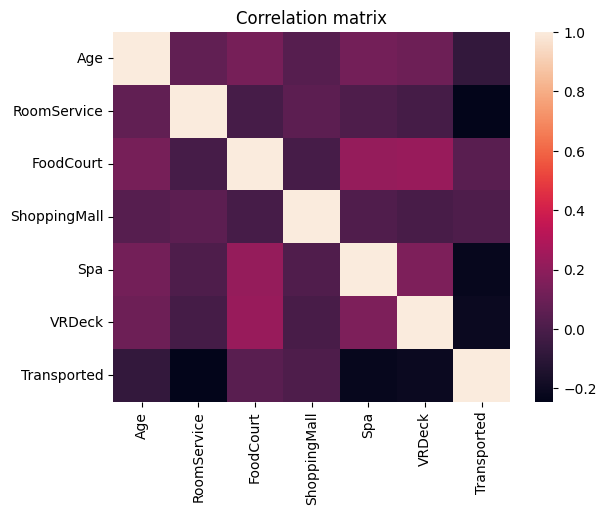

In [6]:
# and now lets plot correlations

corr_matrix = df_train.corr(numeric_only = True)
sns.heatmap(corr_matrix)
plt.title('Correlation matrix')
plt.show()

# we could also check and plot dependence of "transported" with respect to other variables, but come on... it's machine learning, let computer figure 

In [7]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_ytest = pd.read_csv('sample_submission.csv')
df_test['transported']=df_ytest.iloc[:,1].values

def encoding_categories(sequences, categories):  #I put into this function a list of categories we want to encode
  results = np.zeros((len(sequences), len(categories))) # Creates an all-zero matrix of shape (len(sequences), len(categories))
  for i, sequence in enumerate(sequences): # Sets specific indices of results to 1
    for j in range(len(categories)):
      if sequence==categories[j]:
        results[i,j]=1
  return np.array(results)
  

def encoding(df):
  #convert true/false values to 1/0
  df.iloc[:,13]=1*df.iloc[:,13]
  df.iloc[:,2]=1*df.iloc[:,2]
  df.iloc[:,6]=1*df.iloc[:,6]
  
  #normalize numeric values by their maximum value
  for i in [5,7,8,9,10,11]:  
      df.iloc[:,i] = df.iloc[:,i]/max(df.iloc[:,i])

  home_planet=encoding_categories(df.iloc[:,1],['Europa','Earth','Mars'])
  destination=encoding_categories(df.iloc[:,4],['TRAPPIST-1e','PSO J318.5-22','55 Cancri e'])

  #Passenger ID is divided into group number (describing the whole group) and group ID (passenger's number inside their group)
  group, group_id=[],[]
  for x in df.iloc[:,0].values:
    group.append(int(x.split('_')[0]))
    group_id.append(int(x.split('_')[1]))  
  group=np.array(group)
  group_id=np.array(group_id)

  #Cabin number is divided into Deck/Number/Side, where Side can be either P for Port or S for Starboard. (explained in kaggle)
  deck, num, side =[],[],[]
  for x in df.iloc[:,3].values:
    if isinstance(x, float):
      deck.append(np.nan) #if there's a missing value, I assign nan to deck, num and side
      num.append(np.nan) 
      side.append(np.nan)
    else:
      deck.append(x.split('/')[0])
      num.append(int(x.split('/')[1]))
      side.append(x.split('/')[2])
  num=np.array(num)
  deck=encoding_categories(deck,['A','B','C','D','E','F','G','T'])
  side=encoding_categories(side,['P','S'])

  dict={ "group":group, "group id":group_id, 
        "Europa":home_planet[:,0],"Earth":home_planet[:,1],"Mars":home_planet[:,2],
        "cryo_sleep":df.iloc[:,2].values,
        "num":num,
        "A":deck[:,0],"B":deck[:,1],"C":deck[:,2],"D":deck[:,3],"E":deck[:,4],"F":deck[:,5],"G":deck[:,6],"T":deck[:,7], #deck
        "P":side[:,0],"S":side[:,1], #side
        "TRAPPIST-1e":destination[:,0],"PSO J318.5-22":destination[:,1],"55 Cancri e":destination[:,2],
        "age":df.iloc[:,5].values,
        "vip":df.iloc[:,6].values,
        "room service":df.iloc[:,7].values,
        "food":df.iloc[:,8].values,
        "shopping":df.iloc[:,9].values,
        "spa":df.iloc[:,10].values,
        "VRdeck":df.iloc[:,11].values
  }
  return dict

train_data=np.transpose(np.vstack(list(encoding(df_train).values())))
test_data=np.transpose(np.vstack(list(encoding(df_test).values())))
train_labels=df_train.iloc[:,13].values
test_labels=df_test.iloc[:,13].values


In [8]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y")
# path to save pytorch models during training
PATH = f'/notebooks/logs/model_{dt_string}.pt'

In [9]:
# Template of function, modify for proper use
# for calcualting mean and std od dataset
def get_mean_and_std(dataset):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(dataset):
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[1,2])
        channels_squared_sum += torch.mean(data**2, dim=[1,2])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [10]:
# Network prototype
class model_block(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(model_block, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        
    def forward(self, x):
        y = self.linear1(x)
        y = F.relu(y)
        y = self.linear2(y)
        y = F.relu(y)
        return y

class Net(torch.nn.Module):
    def __init__(self, D_in1, H1, D_out1, H2, D_out2):
        super(Net, self).__init__()
        self.block1 = model_block(D_in1, H1, D_out1).double()
        self.block2 = model_block(D_out1, H2, D_out2).double()

    def forward(self, x):
        y = self.block1(x)
        y = self.block2(y)
        return y
#model = Net(10, 100, 80, 100, 1) przykładowe wywolanie

In [11]:
# PREPARE DATA FOR THE NET

def get_rid_of_nan(data, take_mean = False):

    if take_mean: 

    # we replace nan with variable mean

        data2 = np.copy(data)
        means = []
        for variable_num in len(data2[0, 0]):
            column = [data2[row][0][variable_num] for row in range(np.shape(data)[0])]
            for i in range(len(column)):
                if pd.isnull(column[i]):
                    del column[i]
            means.append(np.mean(np.array(column)))

        for row in range(np.shape(data)[0]):        # surely you can do it smartly in a somehow vectorized way
            for col in range(len(data[0, 0])):
                if pd.isnull(data[row, 0][col]):
                    data[row, 0][col] = means[col]

    else:   
        
    # we simply delete rows containing a nan

        for row in range(np.shape(data)[0]):
            if any(pd.isnull(data[row, 0])):
                data = np.delete(data, row, axis = 0)
                row -= 1
                
# let's use our lovely function

print(np.shape(train_data))
get_rid_of_nan(train_data, take_mean = False)
print(np.shape(train_data))
get_rid_of_nan(test_data)

(8693, 27)
(8693, 27)


In [19]:
def how_many_ok(predictions, true_data):
        
        compared = np.array(predictions) == np.array(true_data)
        correct = np.count_nonzero(compared == True)
        return correct

def train(network, train_data, test_data, test = False, iter_num = 10):
        
        # defining our model

        input_dim = np.shape(train_data)[1]     # number of variables
        output_dim = 1                          # "yes" or "no"
        model = network(input_dim, 100, 80, 100, output_dim)

        # configuring the net

        criterion = torch.nn.BCELoss()          # binary cross entropy loss function
        learning_rate = 3e-4                    # initial lr, internet says best for Adam
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

        # learning loop

        correct_list = []
   
        epoch_num = 100
        for epoch in range(epoch_num):
                print(f'epoch nr {epoch}')
                for x, y in train_data:
                        optimizer.zero_grad()           # clear gradient of loss function
                        results = model(x)              # calculate predictions
                        loss = criterion(results, y)    # calculate loss
                        loss.backward()                 # calculate gradient
                        optimizer.step()                # update parameters
                        
                if epoch % 5:
                        correct_list.append(how_many_ok(model(test_data[0]), test_data[1]))

        # plot loss function on test data
        
        if test:

                wrong_list = [np.shape(test_data)[0] - c for c in correct_list]

                names = []
                plt.plot(correct_list, range(epoch_num), color = "green")
                names.append("Correct guesses")
                plt.plot(wrong_list, range(epoch_num), color = "red")
                names.append("Wrong guesses")
                plt.yscale("log")
                plt.ylabel("Number of guesses")
                plt.xlabel("Epoch number")
                plt.title("Accuracy of the net on test data")
                plt.legend(names, bbox_to_anchor = [1, 1])
                plt.grid()
                plt.show()
        
        # and finally

        return model

In [42]:
a = [1, 2, 3, 4, 5]
for i in range(len(a)):
    print(i)
    if i == 3:
        del a[i]
print(a)

0
1
2
3
4
[1, 2, 3, 5]
